# Basic data Analysis

In [1]:
!pip install fuzzywuzzy
!pip install plotly
!pip install gensim
!pip install webcolors

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
import plotly.express as px

In [3]:
majors = pd.read_csv(r"majors.csv")
users = pd.read_csv(r"users.csv")

In [4]:
majors.head()

MAJOR_ID               MAJOR_NAME
0  fafc74b2-2815-4bef-b011-c8a37e5073c2     Chemical Engineering
1  a731d3b9-ec07-4d09-83fd-ed443bd2b731    Undergraduate Pathway
2  61aa9457-4f86-4954-86d4-b855167fd34b  Pre-General Engineering
3  1b3bff54-b2bb-4fa3-bc8e-a8d525097c17              Social Work
4  47402f29-939a-4d31-bea3-765581941d55               Accounting

In [5]:
majors.MAJOR_NAME.value_counts()

Astronomy (BS)                                    1
Biostatistics and Bioinformatics                  1
Marine Biology                                    1
Solar Energy Engineering and Commercialization    1
Sociology and Psychology                          1
                                                 ..
Industrial Engineering-M                          1
COUN-MA                                           1
Nursing-Collaborative                             1
Pre-Graphic Design, Arch                          1
Computer Science Honors                           1
Name: MAJOR_NAME, Length: 14726, dtype: int64

### Note: There are a lot distinct majors which is also mentioned on the problem statement
Let's analyze these names


In [6]:
print(f"There are total {majors.MAJOR_NAME.nunique()} distinct names")

There are total 14726 distinct names


In [7]:
majors.MAJOR_NAME.sort_values().unique().tolist()[:20]

[' Applied Legal Studies (BA, BS)',
 ' International Relations',
 '(OLD) Comm Sci & Disorders',
 '(OLD) Int Studies:Intl Affair',
 '*IT Applications Dev Opt',
 '*IT Bus/Systems Analysis Opt',
 '-',
 '3-2 Engineering',
 '3D Animation and Game Design',
 '3D Digital Design',
 '4+1 Undergraduate Engineering',
 'A&S - Open Option (XXAS)',
 'A&S 3-3 Law Program',
 'A&S Business-Dual',
 'A&S Non-Degree',
 'A&S/Business Dual',
 'AA Degree',
 'ACCT-ADL',
 'ACCT-BSBA',
 'ACCT-MS']

### Note:
There are a lot of names such as 'AA Degree','ACCT-ADL', 'ACCT-BSBA', 'ACCT-MS' etc. which does not have a full form. Given a chance I would love to know those in order to formulate better groups. Here, for simplicity I would group those others or have sub-groups of others such as "Others-MS", "Others-BS" etc.

In [8]:
# majors["major_group_id"]=

# df['PETALS'] = df['BLOOM'].str.extract('(\\(.*?)\\)', expand=False).str.strip()
no_acc = majors.MAJOR_NAME.str.extract(r'([A-Z]+\-+[A-Z]+)+', expand=False).nunique()
print(f"There are {no_acc} accronyms of majors")

There are 469 accronyms of majors


In [9]:
majors["major_accronyms"]= majors.MAJOR_NAME.str.extract(r'([A-Z]+\-+[A-Z]+)+', expand=True)
majors["major_accronyms"].dropna().head(20)

7        MICR-PHD
32        HIST-BA
54        FINE-BA
59       PHTR-DPT
109     NURS-BSNU
110       INBU-MS
116       BIOL-BS
121       COUN-MA
122    PHRD-PHRMD
142       CHEM-BS
144       PSYC-BA
166      FINE-BFA
167      EDHD-PHD
172     MGMT-BSBA
175       GEOS-MA
176      PADM-MPA
182       EVSC-MS
193       COMM-BA
220       GEOG-BA
221      SOCI-MIN
Name: major_accronyms, dtype: object

## Now let's group those names
### Approach
There are endless possibilities to group these names. Some of the ways I could think of are-
- 1. Looking into similar names using keywords. But it will not scale well for larger applications and will be tidious for 14,726 distinct names
- 3. Find cosine similarity using bag of words and then group based on some threshold
- 4. Topic modelling using LDA to check if there is a clear pattern in the data and then group the names using k-means. This would scale up really well and can take simlar names based on their stems or root into account. FYI - This is something I worked in one my previous projects(with my Ex-employer)

I will try approach 4 since it is the most scalable solution here

In [23]:
!pip install nltk
#Libraries for preprocessing
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import webcolors

#Download once if using NLTK for preprocessing
import nltk
nltk.download('punkt')
nltk.download('wordnet')

#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from fuzzywuzzy import fuzz

#Libraries for clustering
from sklearn.cluster import KMeans

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sukanyasaha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sukanyasaha/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [11]:
text1 = majors["MAJOR_NAME"].astype("str")

### Data Cleaning:
Here I am removing stop words, punctuations, digits

In [72]:
# remove_stopwords += ["pre", "Pre", "PRE"]
text2 = [remove_stopwords(x)\
        .translate(str.maketrans(string.punctuation, ' '*len(string.punctuation), ''))\
        .translate(str.maketrans(' ',' ',string.digits))\
        .lower()
        for x in text1]

print("Before: ", text1[10:30].tolist(), "\n")
print("After: ", text2[10:30])

Before:  ['International Commerce/Policy', 'NDCU', 'Undeclared', 'Management', 'Interdisciplinary Studies', 'Info Study: Info Architecture', 'Applied Science', 'Energy Resource Mgmt/Dev', 'Accounting (128)', 'Computer Engineering', 'Computer Science', 'Human Devel and Family Science', 'Mathematics', 'Psychology', 'Pre-Finance', 'Non-Degree', 'English:  Creative Writing', 'Finance', 'Molecular Biology', 'History'] 

After:  ['international commerce policy', 'ndcu', 'undeclared', 'management', 'interdisciplinary studies', 'info study  info architecture', 'applied science', 'energy resource mgmt dev', 'accounting   ', 'computer engineering', 'computer science', 'human devel family science', 'mathematics', 'psychology', 'pre finance', 'non degree', 'english  creative writing', 'finance', 'molecular biology', 'history']


### Note:
Also it is a good idea to retrieve the root words since their are variations of majors names such as Engineering vs Engineer etc.

In [73]:
def stemSentence(sentence):
    porter = PorterStemmer()
    lemma = WordNetLemmatizer()
    token_words = word_tokenize(sentence)
#     stem_sentence = [porter.stem(word) for word in token_words]
    lemma_sentence = [lemma.lemmatize(word) for word in token_words]
    return ' '.join(lemma_sentence)

text3 = pd.Series([stemSentence(x) for x in text2])
print(text3[:5])

0       chemical engineering
1      undergraduate pathway
2    pre general engineering
3                social work
4                 accounting
dtype: object


### Note: 
Now let's create bag of words using scikit learn’s CountVectorizer. This is a step in feature extraction, it will help me to create features from words in major names

In [74]:
#Bag of words
vectorizer_cv = CountVectorizer(analyzer='word')
X_cv = vectorizer_cv.fit_transform(text3)

This will result in a sparse matrix

In [75]:
sparse_matrix = pd.concat([text1, pd.DataFrame(X_cv.toarray())], axis=1)
sparse_matrix.dropna()

MAJOR_NAME  0  1  2  3  4  5  6  7  8  ...  3523  \
0                 Chemical Engineering  0  0  0  0  0  0  0  0  0  ...     0   
1                Undergraduate Pathway  0  0  0  0  0  0  0  0  0  ...     0   
2              Pre-General Engineering  0  0  0  0  0  0  0  0  0  ...     0   
3                          Social Work  0  0  0  0  0  0  0  0  0  ...     0   
4                           Accounting  0  0  0  0  0  0  0  0  0  ...     0   
...                                ... .. .. .. .. .. .. .. .. ..  ...   ...   
14723   History/Theory Of Architecture  0  0  0  0  0  0  0  0  0  ...     0   
14724                 Pre Professional  0  0  0  0  0  0  0  0  0  ...     0   
14725  Evening MBA - Full or Part Time  0  0  0  0  0  0  0  0  0  ...     0   
14726                Finance- Graduate  0  0  0  0  0  0  0  0  0  ...     0   
14727          Global Management (MGM)  0  0  0  0  0  0  0  0  0  ...     0   

       3524  3525  3526  3527  3528  3529  3530  3531  3532  
0         0     0     0     0     0     0     0     0     0  
1         0     0     0     0     0     0     0     0     0  
2         0     0     0     0     0     0     0     0     0  
3         0     0     0     0     0     0     0     0     0  
4         0     0     0     0     0     0     0     0     0  
...     ...   ...   ...   ...   ...   ...   ...   ...   ...  
14723     0     0     0     0     0     0     0     0     0  
14724     0     0     0     0     0     0     0     0     0  
14725     0     0     0     0     0     0     0     0     0  
14726     0     0     0     0     0     0     0     0     0  
14727     0     0     0     0     0     0     0     0     0  

[14728 rows x 3534 columns]

### Note:
Now I will use TF-IDF  to calculate the frequency of the words and compare it to the frequencies of all words in the text to assign it a weighted score of importance. For this I will use scikit learn’s TfidfVectorizer

In [76]:
#TF-IDF (word level)
vectorizer_wtf = TfidfVectorizer(analyzer='word')
X_wtf = vectorizer_wtf.fit_transform(text3)


In [77]:
tf_idf_matrix = pd.concat([text1, pd.DataFrame(X_wtf.toarray())], axis=1)
tf_idf_matrix

MAJOR_NAME    0    1    2    3    4    5    6  \
0                 Chemical Engineering  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1                Undergraduate Pathway  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2              Pre-General Engineering  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3                          Social Work  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4                           Accounting  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                                ...  ...  ...  ...  ...  ...  ...  ...   
14723   History/Theory Of Architecture  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
14724                 Pre Professional  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
14725  Evening MBA - Full or Part Time  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
14726                Finance- Graduate  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
14727          Global Management (MGM)  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

         7    8  ...  3523  3524  3525  3526  3527  3528  3529  3530  3531  \
0      0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1      0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2      0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3      0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4      0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...    ...  ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
14723  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
14724  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
14725  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
14726  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
14727  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

       3532  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  
...     ...  
14723   0.0  
14724   0.0  
14725   0.0  
14726   0.0  
14727   0.0  

[14728 rows x 3534 columns]

In [148]:
#TF-IDF (n-gram level)
vectorizer_ntf = TfidfVectorizer(analyzer='word',ngram_range=(1,2))
X_ntf = vectorizer_ntf.fit_transform(text3)

### LDA(Latent Dirichlet Allocation)

Latent Dirichlet Allocation (LDA) helps to look for patterns to formulate topics of documents based on words. The idea here is to use similar words to build a topic. It is useful for large number of documents and it is highly scalable. The onlly challenge here is to figure out optimun number of topics and give those topics generalized names. Here I have 50 topics and top 5 words per topics

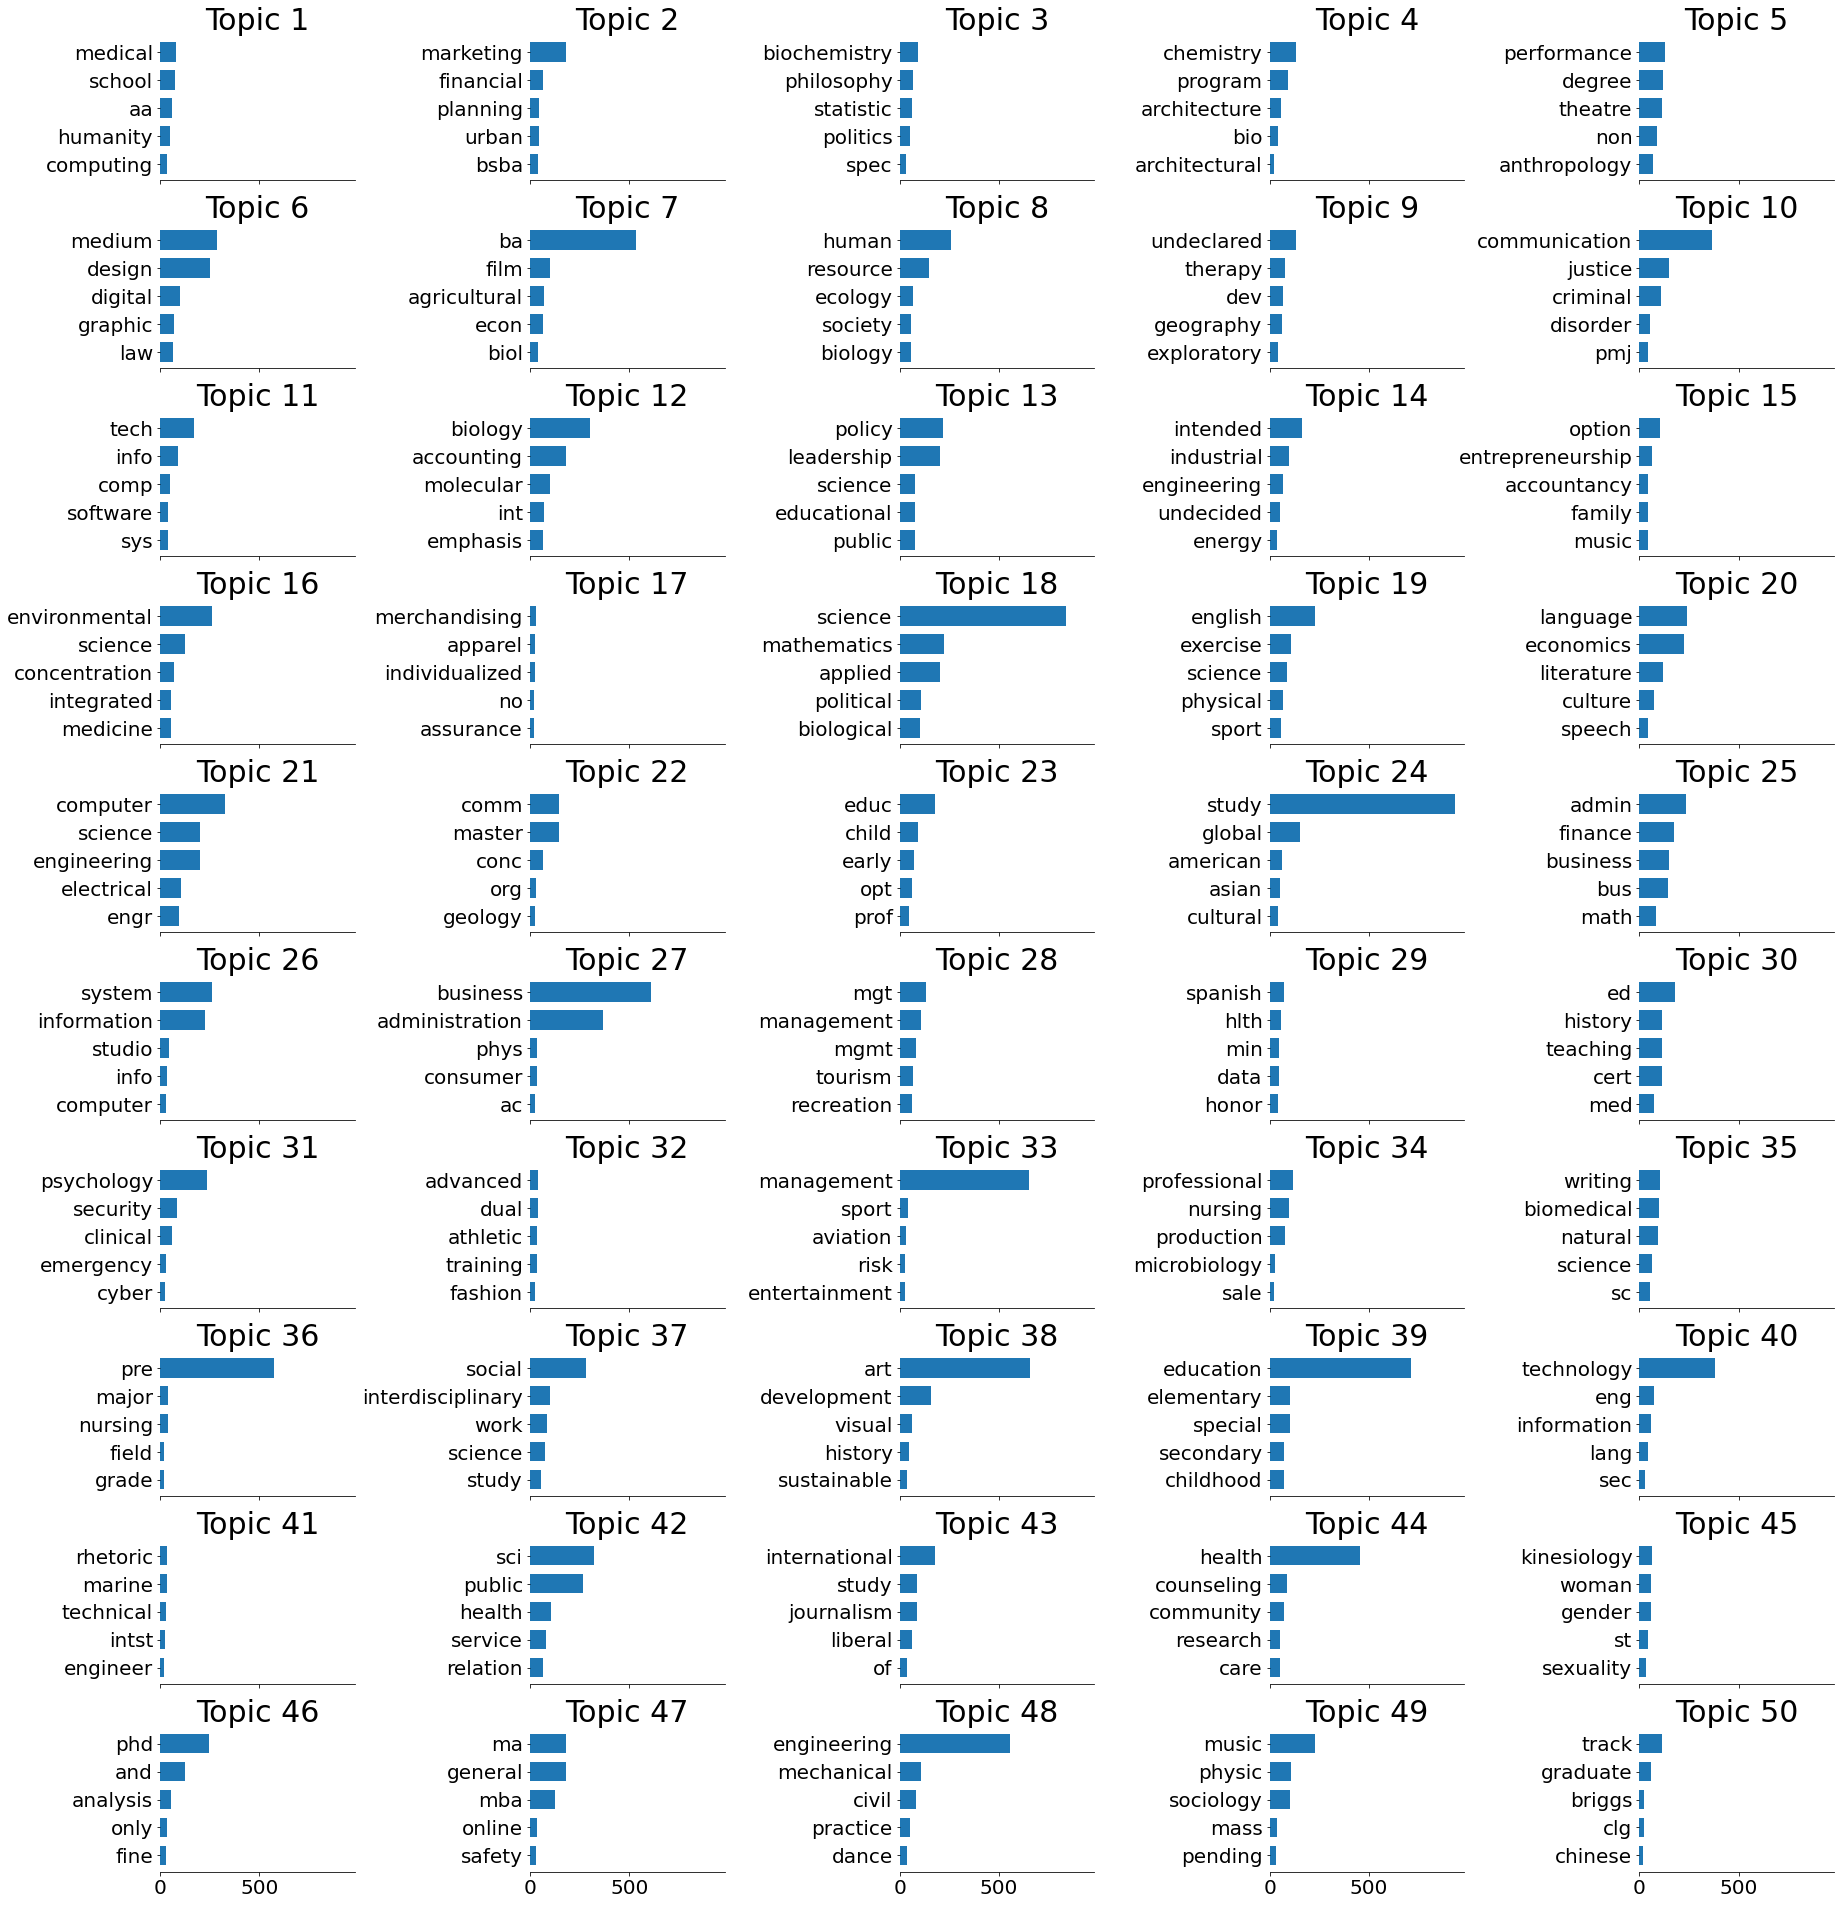

In [79]:
#LDA
lda = LatentDirichletAllocation(n_components=50, learning_decay=0.9)
X_lda = lda.fit(X_cv)

#Plot topics function. Code from: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def plot_top_words(model, feature_names, n_top_words, title, plot_axis_x=10, plot_axis_y=5):
    fig, axes = plt.subplots(plot_axis_x, plot_axis_y, figsize=(30, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
#Show topics
n_top_words = 5
feature_names = vectorizer_cv.get_feature_names()
plot_top_words(X_lda, feature_names, n_top_words, '', plot_axis_x=10, plot_axis_y=5)

### Note:
We see that Language, English, Literature are all in one topic but it also puts Write, Finance, Medicine in one topic which clearly is wrong. Hence, let's tune those hyper parameters a little

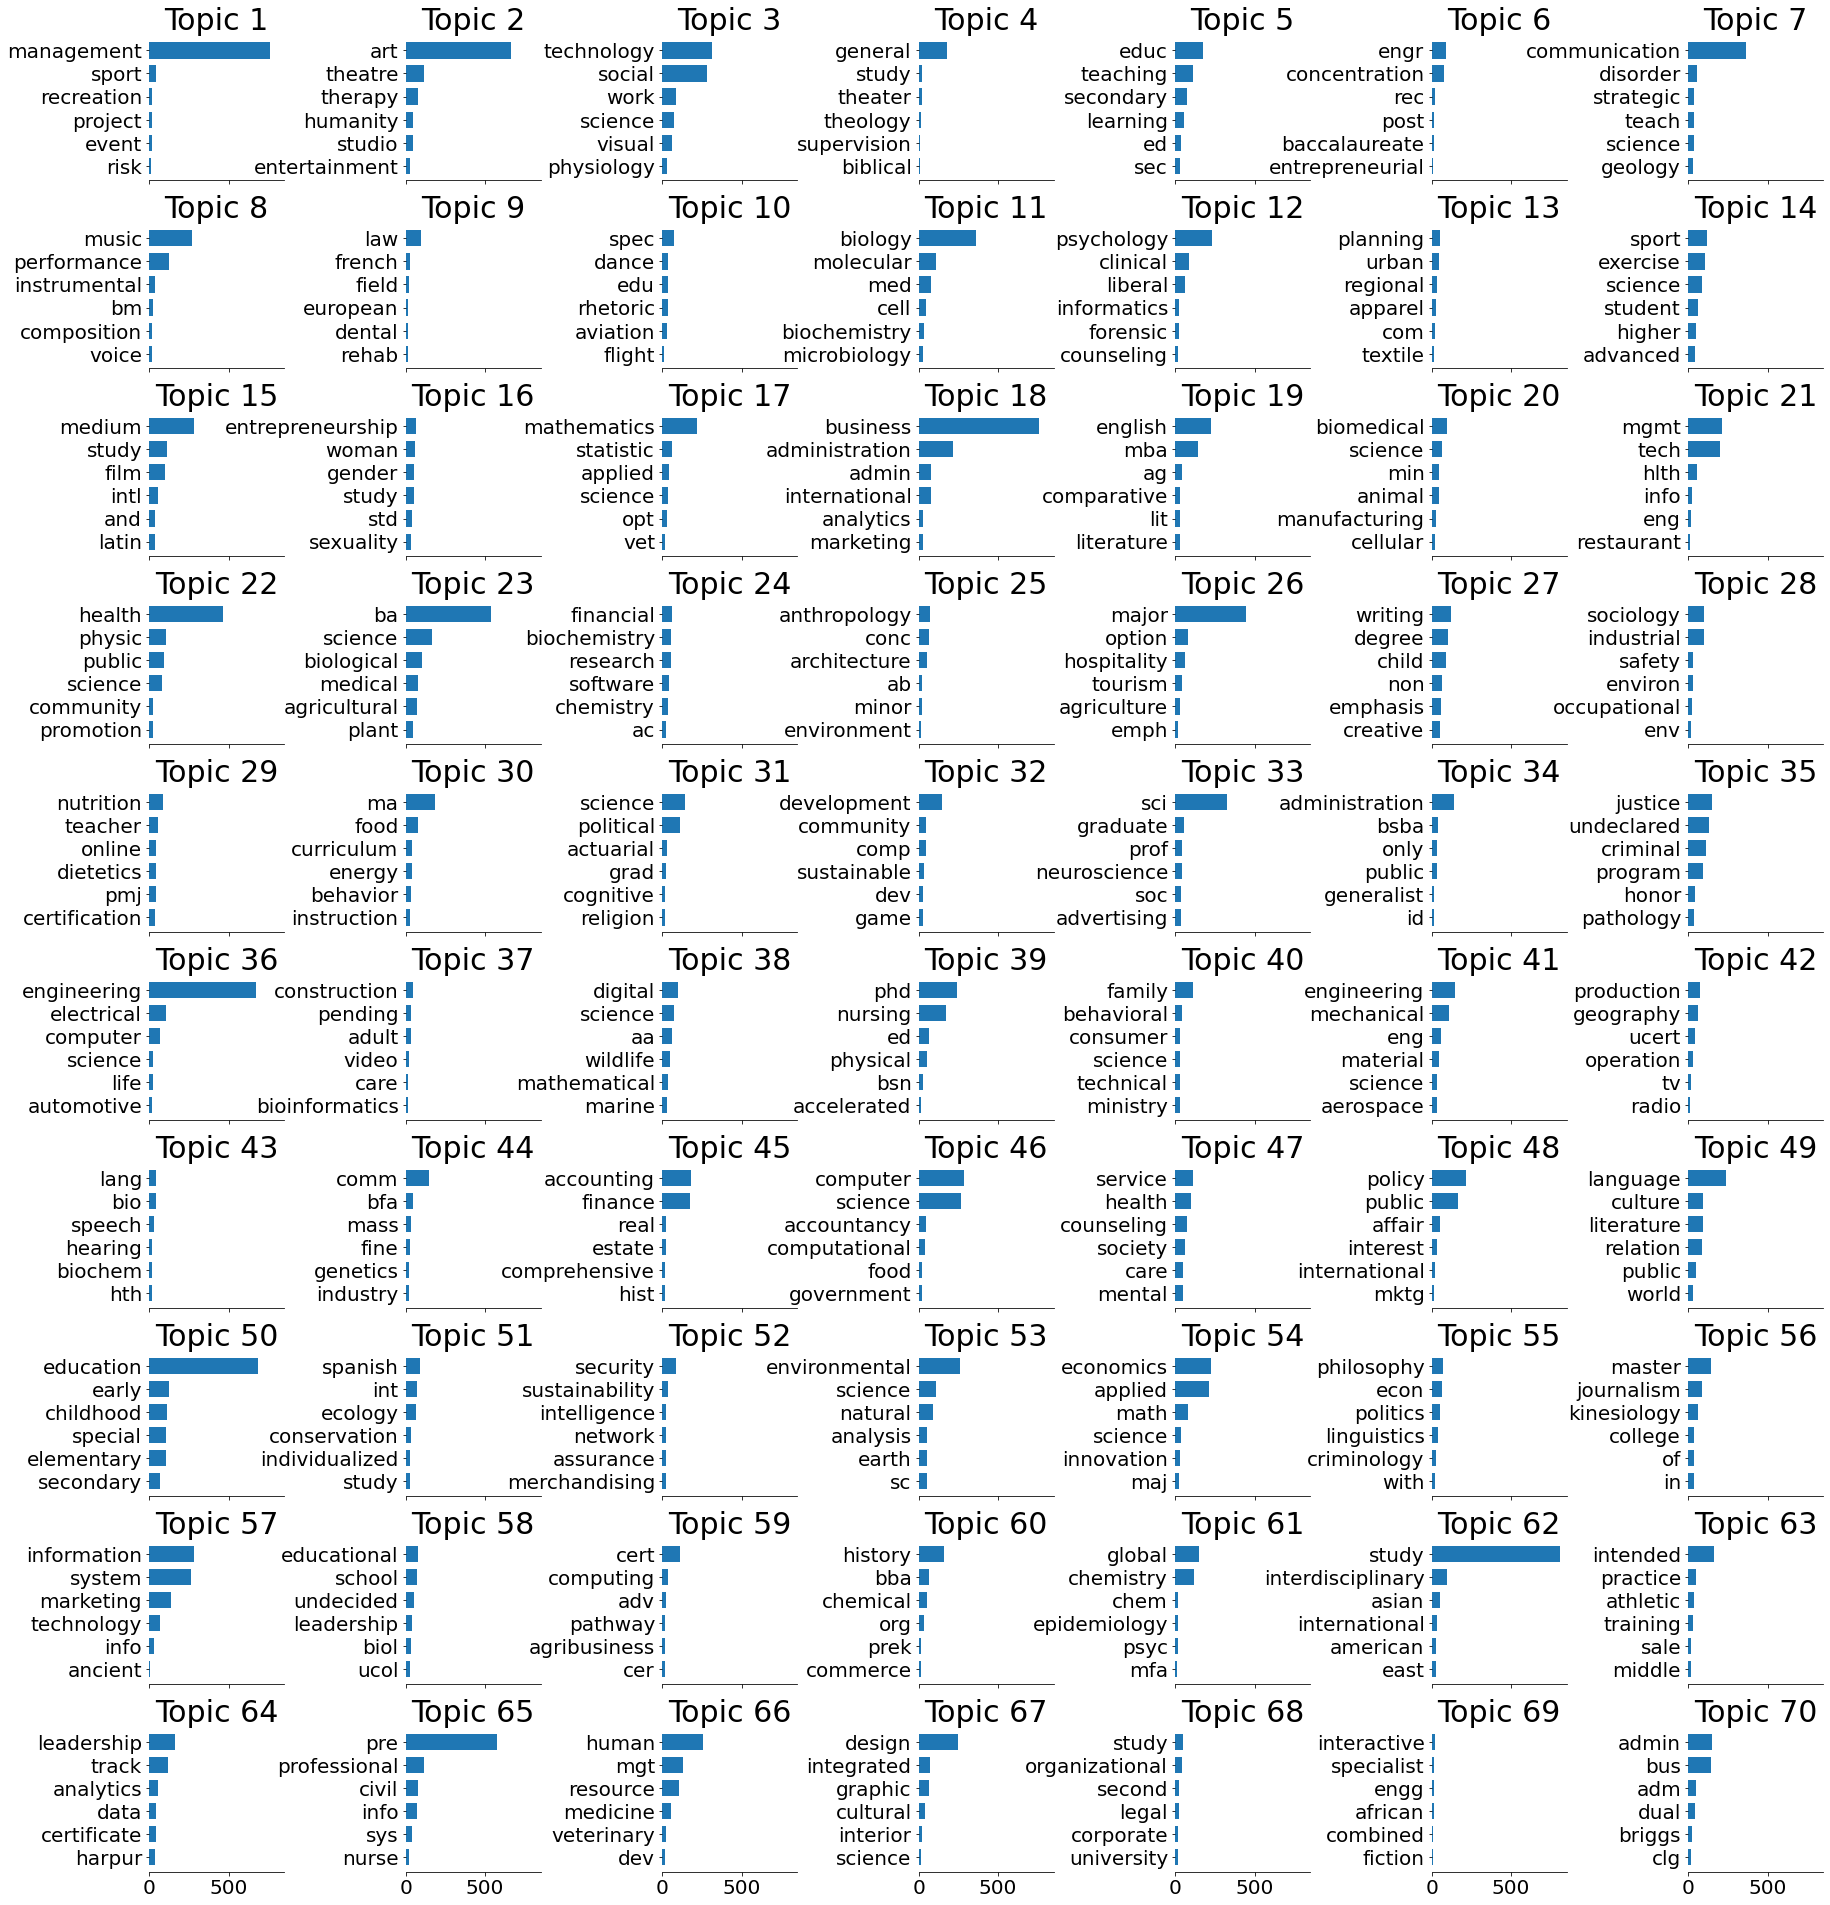

In [80]:
# modifying learning_decay=0.7 and n_components=100
lda = LatentDirichletAllocation(n_components=70, learning_decay=0.7)
X_lda = lda.fit(X_cv)
   
#Show topics
n_top_words = 6
feature_names = vectorizer_cv.get_feature_names()
plot_top_words(X_lda, feature_names, n_top_words, '', plot_axis_x=10, plot_axis_y=7)

#topic 5 and 11 are impressive

### Note:
Yes there is a clear pattern in the data which can be grouped in a better way using clustering technique

In [81]:
text4 = text3[:40]
X_fuzz = pd.crosstab([text4.index,text4],text4).apply(lambda col: [fuzz.token_sort_ratio(col.name, x) 
                                                                   for x in col.index.get_level_values(1)])
X_fuzz

# computer science and computer engineering are close with a score of 67

col_0                                      accounting  applied science  \
row_0 row_1                                                              
0     chemical engineering                         33               34   
1     undergraduate pathway                        26               22   
2     pre general engineering                      24               16   
3     social work                                  19               23   
4     accounting                                  100               24   
5     business administration                      30               21   
6     guest student undergraduate                  16               29   
7     micr phd                                     11               17   
8     robotics                                     33               17   
9     nursing                                      47               18   
10    international commerce policy                31               23   
11    ndcu                                         29               21   
12    undeclared                                   20               24   
13    management                                   30               32   
14    interdisciplinary study                      24               26   
15    info study info architecture                 32               23   
16    applied science                              24              100   
17    energy resource mgmt dev                     12               31   
18    accounting                                  100               24   
19    computer engineering                         47               34   
20    computer science                             31               65   
21    human devel family science                   17               49   
22    mathematics                                  29               23   
23    psychology                                   30               16   
24    pre finance                                  19               31   
25    non degree                                   20               24   
26    english creative writing                     35               31   
27    finance                                      24               36   
28    molecular biology                             7                6   
29    history                                      12               18   
30    pre veterinary medicine                      18               32   
31    music performance                            15               25   
32    hist ba                                      24               27   
33    dental hygiene                               33               48   
34    social science                                8               48   
35    english                                      24               27   
36    wildlife fishery biology management          18               16   
37    land surveying                               42               41   
38    structural biology                            7               24   
39    international business                       31               11   

col_0                                      business administration  \
row_0 row_1                                                          
0     chemical engineering                                      28   
1     undergraduate pathway                                     23   
2     pre general engineering                                   17   
3     social work                                               12   
4     accounting                                                18   
5     business administration                                  100   
6     guest student undergraduate                               20   
7     micr phd                                                  26   
8     robotics                                                  26   
9     nursing                                                   33   
10    international commerce policy                

## Clustering

Now I will cluster the topics for naming those topics. I am showing sum of squared errors or SSE output based on number of clusters.

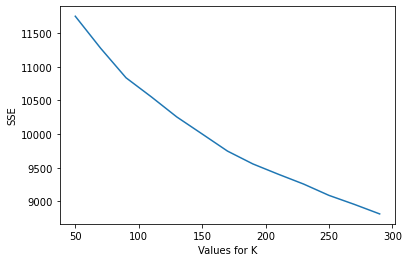

In [139]:
#Test increments of 100 clusters using elbow method
sse={}
for k in np.arange(50,300,20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_wtf)
    sse[k] = kmeans.inertia_
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Values for K')
plt.ylabel('SSE')
plt.show();

### Note:

Increasing the number of clusters decreases SSE, but having 800 major names would probably be too much. Hence, I am going with the first ELBO value which is 150

In [168]:
#Create 150 clusters
def kmeans(X, vect):
    kmeans = KMeans(n_clusters=150)
    kmeans.fit(X)
    result = pd.concat([text1,pd.DataFrame(X.toarray(),columns=vect.get_feature_names())],axis=1)
    result['cluster'] = kmeans.predict(X)
    return result

result_cv = kmeans(X_cv, vectorizer_cv)
result_tf = kmeans(X_wtf, vectorizer_wtf)


### Cluster validation and labeling

Now that i have generated those clusters it is important to vaidate wether these are appropriate and meaningful.
Here, I am trying to label those clusters based on.

For naming it is easier to  give these clusters simple labels based on matrix column names retived from the LDA model that has non zero entries.

In [169]:
def labelling(result):
    clusters = result['cluster'].unique()
    labels = []
    for i in range(len(clusters)):
        subset = result[result['cluster'] == clusters[i]]
        words = ' '.join([x for x in np.where(subset.all()!=0,subset.columns,None) if x and x!='Name' and x!='cluster' and len(x.split()) == 1])
        labels.append(words)
    labels_table = pd.DataFrame(zip(clusters,labels),columns=['cluster','label'])
    result_labelled = pd.merge(result,labels_table,on='cluster',how='left')

    major_groups = result_labelled.rename({'cluster': 'major_group_id','label': 'major_group_name'}, axis=1)[['MAJOR_NAME','major_group_id','major_group_name']]

    major_groups['major_group_name'].replace('MAJOR_NAME','Others',inplace= True)
    major_groups['major_group_name'].replace('MAJOR_NAME ','',inplace= True)

    major_groups['major_group_name'].replace(r'MAJOR_NAME\ ','',inplace= True, regex= True)
    return major_groups

major_groups_bag_of_words = labelling(result_cv)
major_groups_tf = labelling(result_tf)

### Here are the final labels

In [170]:
major_groups_bag_of_words.loc[100:120]

MAJOR_NAME  major_group_id        major_group_name
100                     Sociology              81               sociology
101          Engr-MechEngr (MENG)              84                    engr
102  Entrepreneurship Certificate               6                  Others
103    Bus Adm: Mgmt & Leadership              76              leadership
104  Undeclared  Undergrad. Major              16                   major
105             Political Science              11                 science
106                  Theatre Arts             141                 theatre
107       Engineering: First Year               5             engineering
108          Pre-Computer Science              19        computer science
109                     NURS-BSNU               6                  Others
110                       INBU-MS               6                  Others
111                  Nursing MANE              50                  Others
112                 Media Studies              63            medium study
113         Healthcare Management             110              management
114              Pre-Nursing MANE              54                     pre
115                    Media Arts              37                  medium
116                       BIOL-BS               6                  Others
117    Pre-Mechanical Engineering              26  engineering mechanical
118                          NDGR               6                  Others
119         CINEMA AND MEDIA ARTS              37                  medium
120       Coastal Zone Management             110              management

In [187]:
# #Visualise sizes of supermarket categories (manually added to result_labelled) and clean clusters
# result_summary = pd.pivot_table(result_labelled,index=['label','category'],values=['Name'],aggfunc='count').reset_index().rename(columns={'Name':'count'})
# result_treemap = result_summary[(result_summary['label'] != '') & (result_summary['count'] > 1)]
# fig = px.treemap(result_treemap,path=['category','label'],values='count')
# fig.show();
result_summary_groups_bag_of_words = pd.merge(major_groups_bag_of_words, pd.pivot_table(major_groups_bag_of_words,index=['major_group_name'],values=['major_group_id'],aggfunc='count').reset_index().rename(columns={'major_group_id':'count'}), on="major_group_name") 
result_summary_groups_tf = pd.merge(major_groups_tf, pd.pivot_table(major_groups_tf,index=['major_group_name'],values=['major_group_id'],aggfunc='count').reset_index().rename(columns={'major_group_id':'count'}), on="major_group_name") 



# result_summary_groups_tf= pd.pivot_table(major_groups_tf,index=['major_group_name'],values=['major_group_id'],aggfunc='count').reset_index().rename(columns={'major_group_id':'count'})


### Bag of Words Result

In [192]:
result_treemap = result_summary_groups_bag_of_words[(result_summary_groups_bag_of_words['major_group_name'] != '') & (result_summary_groups_bag_of_words['major_group_name'] != 'Others') & (result_summary_groups_bag_of_words['count'] > 1)]
fig = px.treemap(result_treemap,path=['major_group_name', 'MAJOR_NAME'],values='count')
fig.show();

## TF Results

In [190]:
result_treemap = result_summary_groups_tf[(result_summary_groups_tf['major_group_name'] != '') & (result_summary_groups_tf['major_group_name'] != 'Others') & (result_summary_groups_tf['count'] > 1)]
fig = px.treemap(result_treemap,path=['major_group_name', 'MAJOR_NAME'],values='count')
fig.show();

In [164]:
major_full_data = pd.merge(majors, major_groups, on= "MAJOR_NAME" )

major_full_data[["major_group_id", "major_group_name"]].to_csv("major_groups.csv")
major_full_data[["MAJOR_ID","major_group_id"]].to_csv("major_group_mapping.csv")